In [1]:
import gzip
import struct
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score

1. Перших 2 байти завжди порожні тому ми їх пропускаємо зчитуючи >H тип unsigned short який займає 2 байти

2. 3-ій байт вказує на тип даних
  * 0x08: unsigned byte 
  * 0x09: signed byte 
  * 0x0B: short (2 bytes) 
  * 0x0C: int (4 bytes) 
  * 0x0D: float (4 bytes) 
  * 0x0E: double (8 bytes)
  
3. Наступний байт вказує кількість вимірів матриці

4. Далі послідовно для кожного виміру вказано його розмір як 4-байтове ціле число. Тобто, починаючи з п’ятого байту, три групи по 4 байти вказують на розмірність тривимірної матриці, а саме

In [2]:
print('Labels shape')

with gzip.open('dataset/train-labels-idx1-ubyte.gz', 'rb') as f:
    print(struct.unpack('>HBB', f.read(4)))
    print(struct.unpack('>I', f.read(4)))

print('\nImages shape')
with gzip.open('dataset/train-images-idx3-ubyte.gz', 'rb') as f:
    print(struct.unpack('>HBB', f.read(4)))
    print(struct.unpack('>III', f.read(12)))

Labels shape
(0, 8, 1)
(60000,)

Images shape
(0, 8, 3)
(60000, 28, 28)


In [3]:
# script for reading MNIST file format
def read_idx(filename):
    with gzip.open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [4]:
raw_train = read_idx('dataset/train-images-idx3-ubyte.gz')
X_train = raw_train.reshape(60000, 28 * 28)
y_train = read_idx('dataset/train-labels-idx1-ubyte.gz')

raw_test = read_idx('dataset/t10k-images-idx3-ubyte.gz')
X_test = raw_test.reshape(10000, 28 * 28)
y_test = read_idx('dataset/t10k-labels-idx1-ubyte.gz')

In [5]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=300, n_jobs=-1, verbose=True).fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.0min finished


In [8]:
# save classifier
from sklearn.externals import joblib
joblib.dump(clf, 'app/classifiers/random-forest.pkl') 

['app/classifiers/random-forest.pkl']

In [9]:
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    2.6s finished


0.97070000000000001

In [10]:
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[ 969    1    0    0    0    2    3    1    3    1]
 [   0 1121    3    3    0    2    3    0    2    1]
 [   6    0 1000    5    2    0    4    9    6    0]
 [   1    0    7  978    0    5    0    9    8    2]
 [   1    0    0    0  958    0    5    0    3   15]
 [   2    0    1   13    5  856    5    2    5    3]
 [   7    3    0    0    3    4  938    0    3    0]
 [   1    2   17    2    1    0    0  992    2   11]
 [   4    0    6    6    4    5    3    4  933    9]
 [   7    5    2    9   12    3    1    4    4  962]]


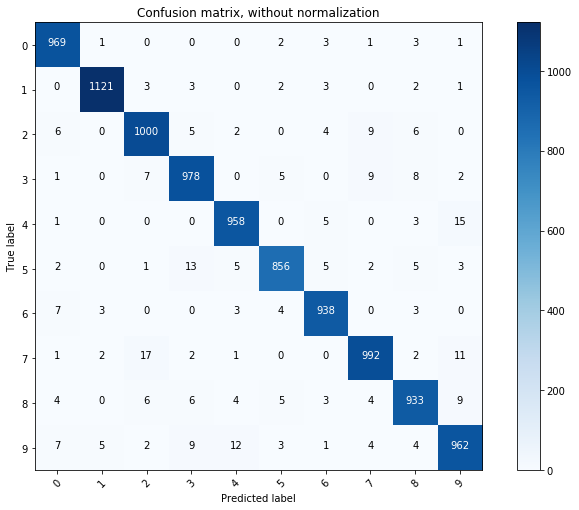

In [11]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 7))
plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[  9.89e-01   1.02e-03   0.00e+00   0.00e+00   0.00e+00   2.04e-03
    3.06e-03   1.02e-03   3.06e-03   1.02e-03]
 [  0.00e+00   9.88e-01   2.64e-03   2.64e-03   0.00e+00   1.76e-03
    2.64e-03   0.00e+00   1.76e-03   8.81e-04]
 [  5.81e-03   0.00e+00   9.69e-01   4.84e-03   1.94e-03   0.00e+00
    3.88e-03   8.72e-03   5.81e-03   0.00e+00]
 [  9.90e-04   0.00e+00   6.93e-03   9.68e-01   0.00e+00   4.95e-03
    0.00e+00   8.91e-03   7.92e-03   1.98e-03]
 [  1.02e-03   0.00e+00   0.00e+00   0.00e+00   9.76e-01   0.00e+00
    5.09e-03   0.00e+00   3.05e-03   1.53e-02]
 [  2.24e-03   0.00e+00   1.12e-03   1.46e-02   5.61e-03   9.60e-01
    5.61e-03   2.24e-03   5.61e-03   3.36e-03]
 [  7.31e-03   3.13e-03   0.00e+00   0.00e+00   3.13e-03   4.18e-03
    9.79e-01   0.00e+00   3.13e-03   0.00e+00]
 [  9.73e-04   1.95e-03   1.65e-02   1.95e-03   9.73e-04   0.00e+00
    0.00e+00   9.65e-01   1.95e-03   1.07e-02]
 [  4.11e-03   0.00e+00   6.16e-03   6.16e-03   4.11

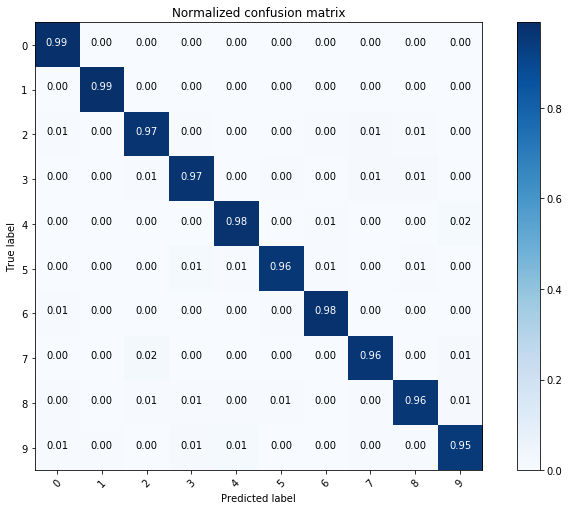

In [12]:
# Plot normalized confusion matrix
plt.figure(figsize=(10, 7))
plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], normalize=True,
                      title='Normalized confusion matrix')

In [13]:
plt.show()

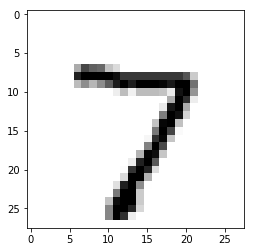

In [14]:
plt.imshow(X_test[0].reshape(28, 28), cmap="binary")